In [1]:
import numpy as np

import torch
import torch.utils.data

import datasets
import metaimage
import nnet
import voxel
import display

%load_ext autoreload
%autoreload 2

## Dataset generation

The dataset used for this prototype is a synthetic dataset consisting of masks a 16x16x16 cube centered in a 32x32x32 space, with the masks generated from random angles around the cube.

This is intended as a simple test to identify if a basic, consistent 3D shape can be recovered from a collection of masks.

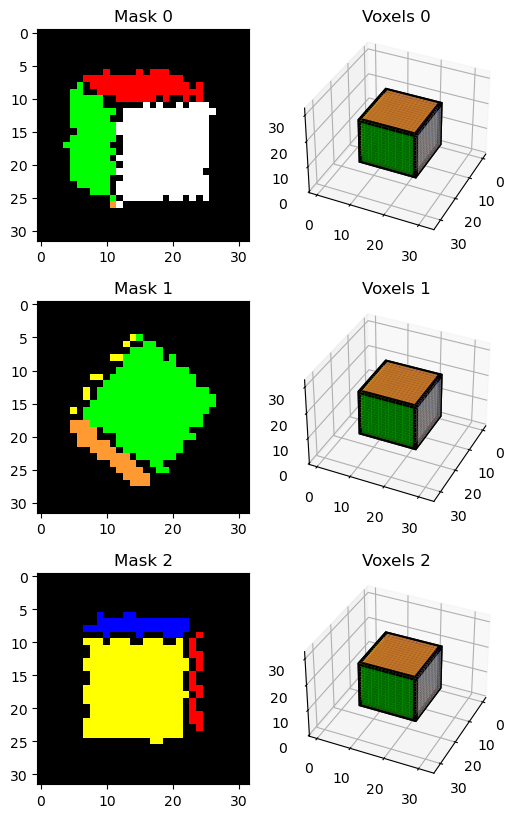

In [2]:
SIDE_LENGTH = 16
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)
BATCH_SIZE = 100

train_auto_dataset = datasets.synth.Rubiks(SIDE_LENGTH, SPACE_SIZE, 1000, train=True)
val_auto_dataset = datasets.synth.Rubiks(SIDE_LENGTH, SPACE_SIZE, 100)

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            (f"Mask {i}", metaimage.ColourImage.from_tensor(train_auto_dataset[i][0])),
            (f"Voxels {i}", voxel.ColourVoxel.from_array(train_auto_dataset[i][1][1])),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

## GAN

To recover the shape, a GAN is used.

### Generator

The generator is a 3D convolutional network. The latent space is mapped linearly to a 32x4x4x4 tensor. This is then repeatedly upsampled using convolutional layer followed by a strided transpose convolution. This doubles the dimensions and halves the number of channels at each stage, to reach a 4x32x32x32 tensor. Finally, this is passed through a resnet block for refinement, and a final convolutional layer to produce a 1x32x32x32 tensor.

This tensor can then be returned, to provide a voxel representation, or a mask is created from a random angle around the cube to produce a 32x32 mask.

### Discriminator

The discriminator is a 2D resnet. This takes in a 32x32 mask, passes it through a resnet block and downsample using a strided convolution, halving the dimensions and doubling the number of channels at each stage. This is until a 4x4 mask is produced, which is then flattened and passed through a linear layer to produce a single label indicating the probability that the mask is real.

In [8]:
LATENT_SIZE = 12
BASE_CHANNELS = 4
DISCRIMINATOR_CHANNELS = 4

# trainer.load_state("models/cube_vae.pt")

discriminator = nnet.generators.MaskDiscriminator(
    base_channels=DISCRIMINATOR_CHANNELS,
    mask_shape=IMAGE_SIZE,
    dropout=0.1,
    in_channels=3,
)

generator = nnet.generators.ColourVoxelGenerator(
    latent_size=LATENT_SIZE,
    base_channels=BASE_CHANNELS,
    space_side_length=SPACE_SIZE[0],
    dropout=0.1,
)

gan_trainer = nnet.training.GANTrainer(
    generator,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

In [9]:
gan_trainer.train(
    train_auto_loader,
    val_auto_loader,
    51,
    path="models/cube_vae_gan",
    noise=0.3,
    gen_train_thresh=1.5,
    dis_train_thresh=1.5,
)

Epoch 25/51 | val loss (gen/dis): 2.0275/1.5578 | train loss: 1.41(22)/0.66(22):  49%|████▉     | 25/51 [14:54<15:30, 35.80s/it]


KeyboardInterrupt: 

Model models/cube_vae_gan_0.pt is loaded from epoch 0 , loss 0.7185
Model models/cube_vae_gan_1.pt is loaded from epoch 10 , loss 1.1393
Model models/cube_vae_gan_2.pt is loaded from epoch 20 , loss 1.9963


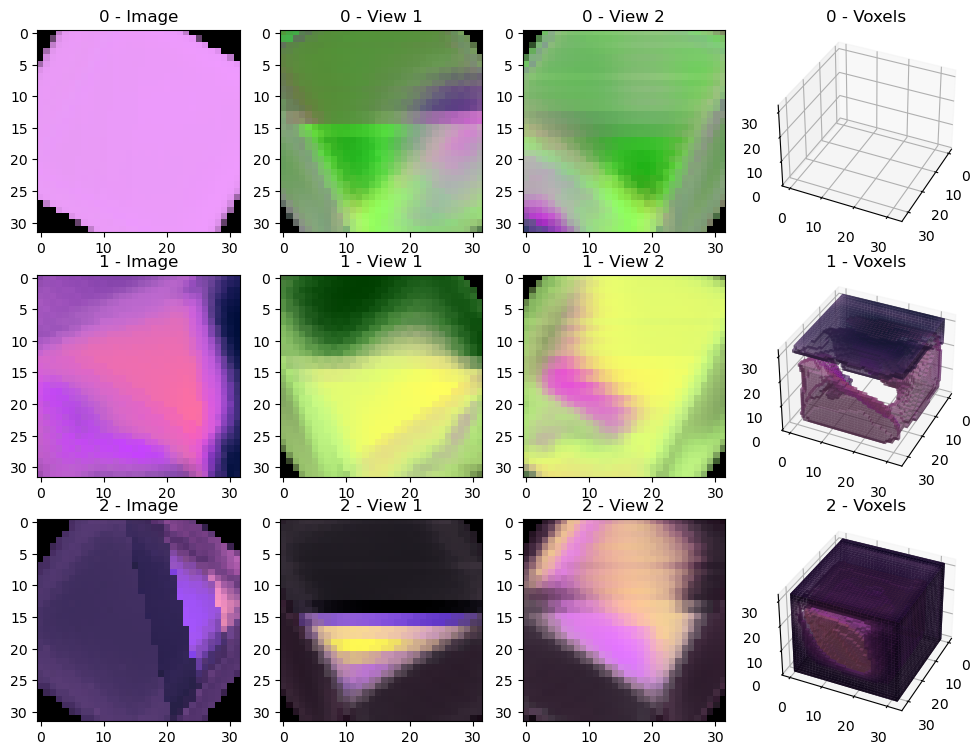

In [10]:
MODELS = (0, 2)

generator.eval()
generator.to("cuda")

N_MODELS = MODELS[1] - MODELS[0] + 1

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for i in range(N_MODELS):
    model_n = MODELS[0] + i
    gan_trainer.load_state(f"models/cube_vae_gan_{model_n}.pt")

    mask = metaimage.ColourImage.from_tensor(
        generator(gen_input, return_mask=True)[0], title=f"{model_n} - Image"
    )
    voxels = voxel.ColourVoxel.from_tensor(
        generator(gen_input, return_voxels=True)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - View 1", voxels.create_image(-np.pi / 3, -np.pi / 3)),
            (f"{model_n} - View 2", voxels.create_image(2 * np.pi / 3, 2 * np.pi / 3)),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * N_MODELS))
display.show()

Model models/cube_vae_gan_8.pt is loaded from epoch 80 , loss 0.3584


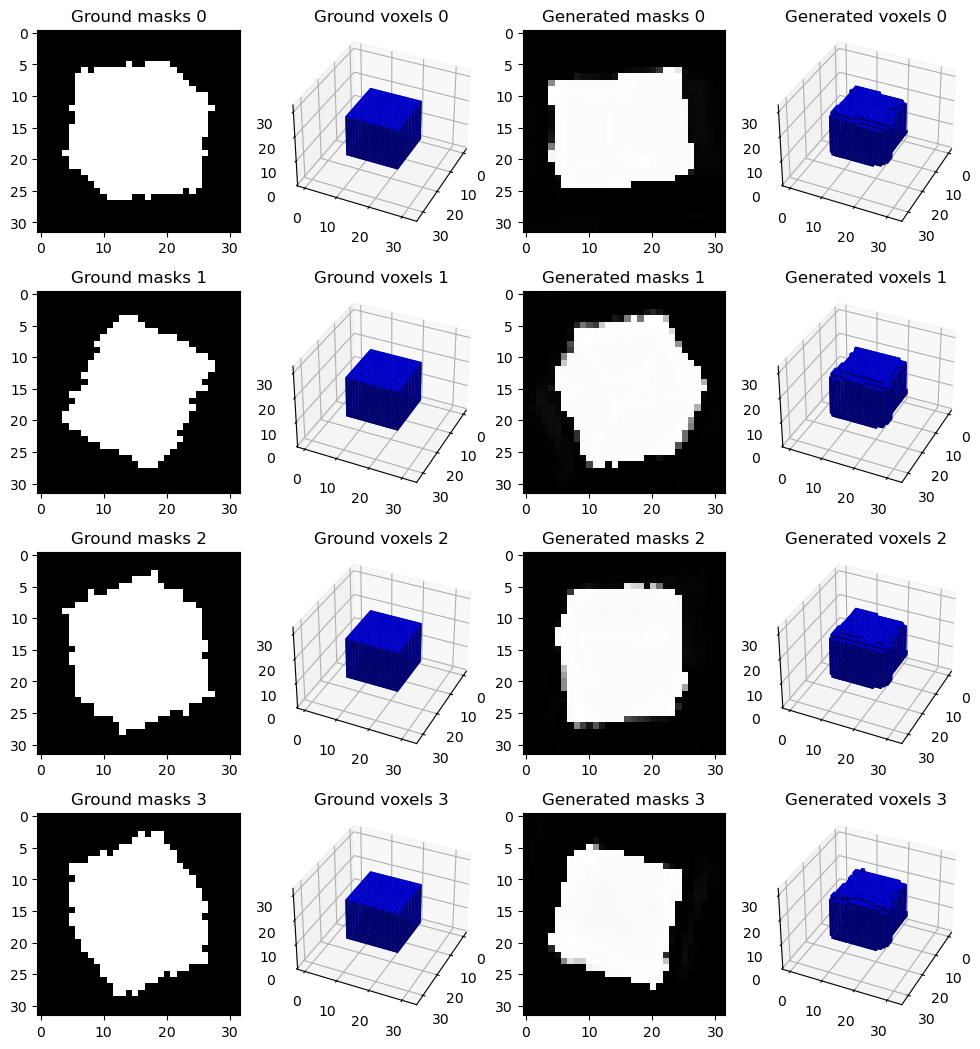

In [ ]:
MODEL = 8

gan_trainer.load_state(f"models/cube_vae_gan_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = generator(gen_input, return_mask=True)[:4]
voxels = generator(gen_input, return_voxels=True)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxel.SimpleVoxel.from_tensor(voxels[i], title=f"Generated voxels {i}")
    cur_mask = metaimage.Mask.from_tensor(masks[i], title=f"Generated masks {i}")
    ground_mask, ground_voxels = train_auto_dataset[i][1]
    ground_mask = metaimage.Mask.from_tensor(ground_mask, title=f"Ground masks {i}")
    ground_voxels = voxel.SimpleVoxel.from_array(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(12, 13))
display.show()